In [1]:
import sys
sys.path.insert(0,'..')
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from my_relu import ReLUAlpha

In [2]:
relu_0 = lambda: ReLUAlpha(0)
relu_1 = lambda: ReLUAlpha(1)

def get_mlp_network(relu_fn, nb_neurons=512, nb_hidden_layers=2):
    
    modules = [torch.nn.Linear(28 * 28, nb_neurons), relu_fn()]
    for _ in range(nb_hidden_layers-1):
        modules.append(torch.nn.Linear(nb_neurons, nb_neurons))
        modules.append(relu_fn())
    modules.append(torch.nn.Linear(nb_neurons, 10))

    return torch.nn.Sequential(*modules)

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

def copy_params(net1, net2):
    params1 = net1.named_parameters()
    params2 = net2.named_parameters()

    dict_params2 = dict(params2)

    for name, param in params1:
        if name in dict_params2:
            dict_params2[name].data.copy_(param.data)

            
def build_models(nb_neurons=512, nb_hidden_layers=2, precision=32):
    net1 = get_mlp_network(relu_0, nb_neurons, nb_hidden_layers)
    net2 = get_mlp_network(relu_1, nb_neurons, nb_hidden_layers)

    copy_params(net1, net2)

    for net in [net1, net2]:
        net.to(device)
        if precision == 16:
            net.half()
        if precision == 64:
            net.double()

    return net1, net2

In [3]:
nb_experiments = 100 #full paper experiment: nb_experiments = 1000
batch_size = 256

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

df = pd.DataFrame(columns=["precision", "count"])
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Volume by number of layers

In [4]:
nb_neurons = 256
df = pd.DataFrame(columns=["precision", "count", "nb_layers"])
for precision in tqdm([16,32, 64], desc='precision'):
    for nb_layers in tqdm([1,2,3,5,6], desc='nb_layers', leave=False):
        count = 0
        for run_id in tqdm(range(nb_experiments), desc='run', leave=False):
            (net1, net2) = build_models(nb_neurons, nb_layers, precision)
            for x, y in train_loader:
                x = x.to(device)
                if precision == 16:
                    x = x.half()
                if precision == 64:
                    break#x = x.double()
                y = y.to(device)
                same = True
                y1 = net1(x.view(-1, 28 * 28))
                y2 = net2(x.view(-1, 28 * 28))
                l1 = nn.CrossEntropyLoss()(y1, y)
                l2 = nn.CrossEntropyLoss()(y2, y)
                l1.backward(), l2.backward()
                if (net1[0].weight.grad - net2[0].weight.grad).abs().sum() != 0:
                    count += 1
                    break
        df = df.append({"precision": precision,
                        "nb_layers": nb_layers,
                        "count": count}, ignore_index=True)
df.to_csv("volume_estimation_by_number_of_layers_MNIST.csv")

precision:   0%|          | 0/3 [00:00<?, ?it/s]

nb_layers:   0%|          | 0/5 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

nb_layers:   0%|          | 0/5 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

nb_layers:   0%|          | 0/5 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

In [3]:
#df = pd.read_csv('../paper_results/section_3/volume_estimation_by_number_of_layers_MNIST.csv')

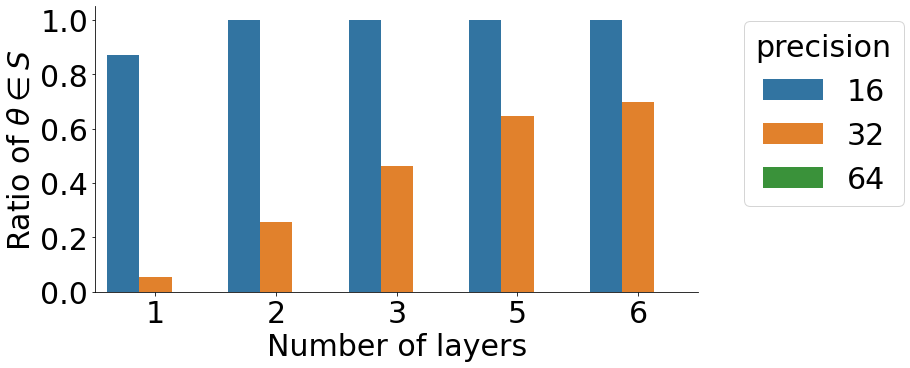

In [4]:
df['ratio'] = df['count'] / nb_experiments
sns.catplot(x = "nb_layers",       
            y = "ratio",       
            hue = "precision",                  
            data = df,     
            kind = "bar",
            height=4.5, aspect=2,
            legend=False
            )

plt.legend(title='precision', fontsize='30', title_fontsize='30', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of layers', fontsize='30');
plt.ylabel('Ratio of ' + r'$\theta \in S$', fontsize='30');
plt.yticks(fontsize='30');
plt.xticks(fontsize='30');
plt.savefig('layers.png')

## Volume by number of neurons

In [ ]:
nb_layers = 3
df = pd.DataFrame(columns=["precision", "count", "nb_layers"])
for precision in tqdm([16,32, 64], desc='precision'):
    for nb_neurons in tqdm([16, 64, 256, 512, 1024], desc='nb_neurons', leave=False):
        count = 0
        for run_id in tqdm(range(nb_experiments), desc='run', leave=False):
            (net1, net2) = build_models(nb_neurons, nb_layers, precision)
            for x, y in train_loader:
                x = x.to(device)
                if precision == 16:
                    x = x.half()
                if precision == 64:
                    x = x.double()
                y = y.to(device)
                same = True
                y1 = net1(x.view(-1, 28 * 28))
                y2 = net2(x.view(-1, 28 * 28))
                l1 = nn.CrossEntropyLoss()(y1, y)
                l2 = nn.CrossEntropyLoss()(y2, y)
                l1.backward(), l2.backward()
                if (net1[0].weight.grad - net2[0].weight.grad).abs().sum() != 0:
                    count += 1
                    break
        df = df.append({"precision": precision,
                        "nb_neurons": nb_neurons,
                        "count": count}, ignore_index=True)


df.to_csv("volume_estimation_by_number_of_neurons_MNIST.csv")

In [5]:
df = pd.read_csv('../paper_results/section_3/volume_estimation_by_number_of_neurons_MNIST.csv')

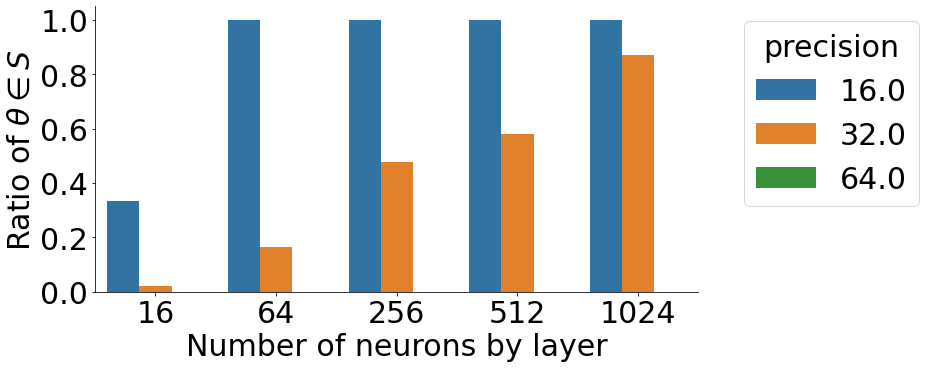

In [6]:
df['ratio'] = df['count'] / nb_experiments
df = df.astype({"nb_neurons": int})
sns.catplot(x = "nb_neurons",       
            y = "ratio",       
            hue = "precision",                  
            data = df,     
            kind = "bar",
            height=4.5, aspect=2,
            legend=False
            )

plt.legend(title='precision', fontsize='30', title_fontsize='30', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of neurons by layer', fontsize='30');
plt.ylabel('Ratio of ' + r'$\theta \in S$', fontsize='30');
plt.yticks(fontsize='30');
plt.xticks(fontsize='30');
plt.savefig('neurons.png')

## Volume by batch size

In [ ]:
nb_layers = 3
nb_neurons = 256

df = pd.DataFrame(columns=["precision", "count", "nb_layers"])
for precision in tqdm([16,32], desc='precision'):
    for batch_size in tqdm([16, 32, 64, 128, 256], desc='batch_size', leave=False):
        count = 0
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
        for run_id in tqdm(range(nb_experiments), desc='run', leave=False):
            (net1, net2) = build_models(nb_neurons, nb_layers, precision)
            for x, y in train_loader:
                x = x.to(device)
                if precision == 16:
                    x = x.half()
                y = y.to(device)
                same = True
                y1 = net1(x.view(-1, 28 * 28))
                y2 = net2(x.view(-1, 28 * 28))
                l1 = nn.CrossEntropyLoss()(y1, y)
                l2 = nn.CrossEntropyLoss()(y2, y)
                l1.backward(), l2.backward()
                if (net1[0].weight.grad - net2[0].weight.grad).abs().sum() != 0:
                    count += 1
                    break
        df = df.append({"precision": precision,
                        "batch_size": batch_size,
                        "count": count}, ignore_index=True)

df.to_csv("volume_estimation_by_batch_size_MNIST.csv")

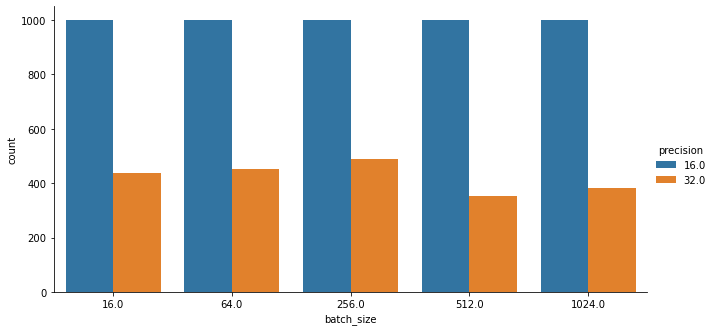

In [7]:
#df = pd.read_csv('../paper_results/section_3/volume_estimation_by_batch_size_MNIST.csv')

sns.catplot(x = "batch_size",       
            y = "count",       
            hue = "precision",                  
            data = df,     
            kind = "bar",
            height=4.5, aspect=2,
            legend=True
            )